In [1]:
import tensorflow

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12224766857450221573
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1751174350
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13735564389115019912
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import os
import tensorflow

# '0번' GPU 사용
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_visible_devices(gpus[0], 'GPU')

if gpus:
    try:
        tensorflow.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" => cpu 사용 강제
# tensorflow.debugging.set_log_device_placement(True)

a = tensorflow.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tensorflow.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tensorflow.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [3]:
from konlpy.tag import Mecab
mecab = Mecab(dicpath='C:/mecab/mecab-ko-dic')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re


#뛰어쓰기 수정
from pykospacing import Spacing
spacing = Spacing()
#맞춤법 수정
from hanspell import spell_checker

import sys
import soynlp
from soynlp.normalizer import *

In [5]:
#불용어 정의
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']
stop = """이	VCP	0.018279601
있	VA	0.011699048
하	VV	0.009773658
것	NNB	0.00973315
들	XSN	0.00689824
그	MM	0.005327252
되	VV	0.00361335
수	NNB	0.003473622
이	NP	0.003361203
보	VX	0.003310379
않	VX	0.0029757
없	VA	0.002920476
나	NP	0.002690479
사람	NNG	0.002073917
주	VV	0.001884579
아니	VCN	0.001870774
등	NNB	0.001822074
같	VA	0.001724522
우리	NP	0.001714509
때	NNG	0.001685684
년	NNB	0.001647755
가	VV	0.001618626
한	MM	0.001584036
지	VX	0.001537763
대하	VV	0.00150378
오	VV	0.001490884
말	NNG	0.001321876
일	NNG	0.001239799
그렇	VA	0.001232062
위하	VV	0.001170618
때문	NNB	0.001146647
그것	NP	0.001099161
두	VV	0.001063053
말하	VV	0.001030587
알	VV	0.000995693
그러나	MAJ	0.000978246
받	VV	0.000924084
못하	VX	0.000904665
일	NNB	0.000880239
그런	MM	0.000879481
또	MAG	0.000870985
문제	NNG	0.000823954
더	MAG	0.000801652
사회	NNG	0.000793459
많	VA	0.000789211
그리고	MAJ	0.000779653
좋	VA	0.000763723
크	VA	0.000758565
따르	VV	0.000738084
중	NNB	0.000733229
나오	VV	0.000725188
가지	VV	0.000720485
씨	NNB	0.000710169
시키	XSV	0.000707893
만들	VV	0.000703797
지금	NNG	0.000699701
생각하	VV	0.000694846
그러	VV	0.000692418
속	NNG	0.00068544
하나	NR	0.000655097
집	NNG	0.000648573
살	VV	0.000648422
모르	VV	0.000645084
적	XSN	0.000643112
월	NNB	0.000639319
데	NNB	0.000636436
자신	NNG	0.000632188
안	MAG	0.000625968
어떤	MM	0.000623237
내	NP	0.000622023
내	VV	0.000614438
경우	NNG	0.000613831
명	NNB	0.00061019
생각	NNG	0.000587433
시간	NNG	0.00057302
그녀	NP	0.000571806
다시	MAG	0.00055618
이런	MM	0.000550263
앞	NNG	0.000548898
보이	VV	0.000542678
번	NNB	0.000542526
나	VX	0.000538126
다른	MM	0.000536306
어떻	VA	0.000533423
여자	NNG	0.000531754
개	NNB	0.000530085
전	NNG	0.00052872
들	VV	0.000514914
사실	NNG	0.000511728
이렇	VA	0.000511576
점	NNG	0.000507935
싶	VX	0.000504749
말	VX	0.000503991
정도	NNG	0.000496102
좀	MAG	0.000492916
원	NNB	0.000492309
잘	MAG	0.000491399
통하	VV	0.000486847
소리	NNG	0.000485633
놓	VX	0.000482751
"""

stoplist = re.split(r'[+ + \t + \n]', stop)
# stoplist = re.split(r'[가-힣]', stop)
# stoplist = re.compile('[가-힣]').findall(stop)
for i in range(0, len(stoplist), 3):
    stopwords.append(stoplist[i])
stopwords= [s for s in stopwords if s != '']

In [6]:
naver_movie = pd.read_table('naver_movie.txt')
naver_shopping = pd.read_table('naver_shopping.txt',names=['label', 'reviews'])
steam = pd.read_table('steam.txt',names=['label', 'reviews'])

In [7]:
naver_movie.rename(columns = {"document":"reviews"}, inplace=True)
naver_movie.drop('id', axis = 1, inplace = True)

In [8]:
naver_shopping['label'] = np.select([naver_shopping.label > 3], [1], default=0)

In [9]:
naver_movie.drop_duplicates(subset=['reviews'], inplace=True)
naver_shopping.drop_duplicates(subset=['reviews'], inplace=True)
steam.drop_duplicates(subset=['reviews'], inplace=True)
print(naver_movie.isnull().values.any())
print(naver_shopping.isnull().values.any())
print(steam.isnull().values.any())


True
False
False


In [10]:
naver_movie['category'] = 'movie'
naver_shopping['category'] = 'shopping'
steam['category'] = 'steam'

In [11]:
total_data = pd.concat([naver_movie, naver_shopping, steam], ignore_index = False)
total_data = total_data.reset_index(drop=True)

In [12]:
total_data

,reviews,label,category
0,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,movie
1,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1,movie
2,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1,movie
3,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1,movie
4,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1,movie
...,...,...,...
494339,한글화해주면 10개산다,0,steam
494340,개쌉노잼 ㅋㅋ,0,steam
494341,노잼이네요... 30분하고 지웠어요...,0,steam
494342,야생을 사랑하는 사람들을 위한 짧지만 여운이 남는 이야기. 영어는 그리 어렵지 않습니다.,1,steam


In [13]:
total_data['reviews'].nunique(), total_data['label'].nunique()
total_data.drop_duplicates(subset=['reviews'], inplace=True) # reviews 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(total_data))
print(total_data.isnull().values.any())


train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

총 샘플의 수 : 493988
True
훈련용 리뷰의 개수 : 395190
테스트용 리뷰의 개수 : 98798


In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

reviews     0
label       0
category    0
dtype: int64
reviews     0
label       0
category    0
dtype: int64
전처리 후 훈련용 샘플의 개수 : 394794
전처리 후 테스트용 샘플의 개수 : 98702


In [15]:
def text_process(text):
    m = re.search('ㅋ+|ㅠ+|ㅜ+', text)
    if m:
        tmp = spacing(text)
        tmp = spell_checker.check(tmp)[2]
        tmp = emoticon_normalize(tmp)
        tmp = re.sub('ㅋ+|ㅠ+|ㅜ+', '', tmp)
        tmp = repeat_normalize(tmp, num_repeats=1)
        return tmp

    else :
        tmp = text
    tmp = spacing(tmp)
    tmp = spell_checker.check(tmp)[2] 
    return tmp

In [ ]:
# def text_process(text):
#     m = re.search('ㅋ+|ㅠ+|ㅜ+', text)
#     if m:
#         return repeat_normalize(re.sub('ㅋ+|ㅠ+|ㅜ+', '', emoticon_normalize(spell_checker.check(spacing(text))[2])), num_repeats=1)

#     else :
#         return spell_checker.check(spacing(text))[2] 


In [ ]:
for k in range(0, len(train_data['reviews'])//50000 + 1):
    print('start ' + str(k))
    if k == 7:
        for i in range(50000*k, len(train_data['reviews'])):
            train_data['reviews'][i] = text_process(train_data['reviews'][i])
        continue
    
    for i in range(50000*k, 50000*k + 50000):
        train_data['reviews'][i] = text_process(train_data['reviews'][i])
    print('finish ' + str(k))
    train_data.to_csv('stores1.csv', encoding = 'utf-8',index = False)


In [16]:
train_data = pd.read_csv('D:/Code/Muchine Learning/TensorFlow/Project/train_data_300000.csv',encoding='utf-8')


In [17]:
for i in range(300001, len(train_data['reviews'])):
    try:
        train_data['reviews'][i] = text_process(train_data['reviews'][i])
        if(i % 50000 == 0):
            strs = 'train_data_' + str(i) + '.csv'
            train_data.to_csv(strs, encoding = 'utf-8',index = False)
            print('strs save')
    except:
        print('pass')
        pass

C:\Users\namgy\anaconda3\envs\python_VM\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


pass
pass
pass
strs save


In [19]:
train_data.to_csv('train_data_final.csv', encoding = 'utf-8',index = False)


In [18]:
len(test_data)

98702

In [20]:
for i in range(0, len(test_data['reviews'])):
    try:
        test_data['reviews'][i] = text_process(test_data['reviews'][i])
        if(i % 30000 == 0):
            strs = 'test_data' + str(i) + '.csv'
            test_data.to_csv(strs, encoding = 'utf-8',index = False)
            print('strs save')
    except:
        print('pass')
        pass

C:\Users\namgy\anaconda3\envs\python_VM\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


strs save
pass
strs save
pass
pass
pass
strs save
pass
pass
strs save


In [21]:
test_data.to_csv('test_data_final.csv', encoding = 'utf-8',index = False)


In [6]:
train_data = pd.read_csv('D:/Code/Muchine Learning/TensorFlow/Project/train_data_final.csv',encoding='utf-8')
test_data = pd.read_csv('D:/Code/Muchine Learning/TensorFlow/Project/test_data_final.csv',encoding='utf-8')


In [7]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True)
train_data['reviews'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())

test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","",regex=True) # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print(train_data.isnull().sum())
print('전처리 후 훈련용 샘플의 개수 :',len(train_data))
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

reviews     0
label       0
category    0
dtype: int64
reviews     0
label       0
category    0
dtype: int64
전처리 후 훈련용 샘플의 개수 : 394296
전처리 후 테스트용 샘플의 개수 : 97932


In [8]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [9]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


#너무 짧은 리뷰는 제거
for i in range(1, len(train_data['tokenized'])):
    if len(train_data['tokenized'][i]) < 2:
        train_data = train_data.drop([i],axis = 0)
        

for i in range(1, len(test_data['tokenized'])):
    if len(test_data['tokenized'][i]) < 2:
        test_data = test_data.drop([i],axis = 0)
        
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)


X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold , rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 67536
등장 빈도가 2번 이하인 희귀 단어의 수: 24893
단어 집합에서 희귀 단어의 비율: 36.85886045960673
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.5492931764340363


In [19]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



단어 집합의 크기 : 42645


리뷰의 최대 길이 : 81
리뷰의 평균 길이 : 11.664266116204487


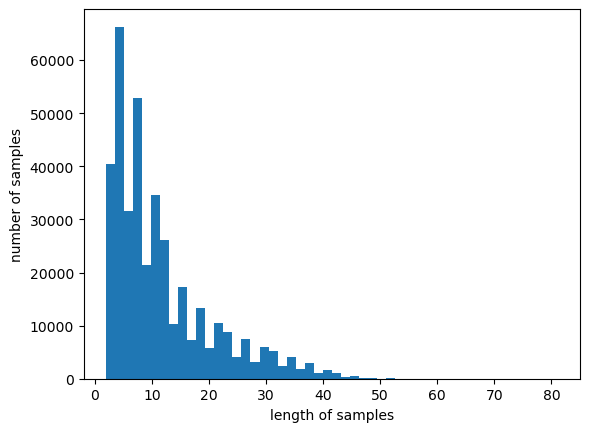

In [20]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.97143018928143


In [22]:

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [40]:
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Flatten, Activation,BatchNormalization
from tensorflow.keras import Input, Model, layers, optimizers, metrics
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf


class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights


    
# kargs = {'vocab_size' : vocab_size,
#          'max_len': max_len,
#          'lstm_size' : 64,
#         'dropout_rate' : 0.5,
#         'hidden_dimension' : 250,
#         'output_dimension' : 1}
sequence_input = Input(shape=(max_len,))
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len)(sequence_input)

lstm = Bidirectional(LSTM(64, dropout=0.5,  return_sequences = True))(embedded_sequences)

lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional(LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)



state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

# hidden = BatchNormalization()(context_vector)
# dense1 = Dense(128, activation="elu")(context_vector)
# dropout_1 = Dropout(0.5)(dense1)
dense2 = Dense(32, activation="elu")(context_vector)
dropout_2 = Dropout(0.5)(dense2)
# dense3 = Dense(32, activation="elu")(dropout_2)
# dropout_3 = Dropout(0.5)(dense3)
dense4 = Dense(16, activation="elu")(dropout_2)
dropout_4 = Dropout(0.5)(dense4)
# dense5 = Dense(8, activation="elu")(dropout_4)
# dropout_5 = Dropout(0.5)(dense5)
output = Dense(1, activation="sigmoid")(dropout_4)
text_model = Model(inputs=sequence_input, outputs=output)

text_model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy'])


#최적화 과정
modelpath = "./best_model.h5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=2, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

In [33]:
text_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 128)      5458560     ['input_2[0][0]']                
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 50, 128)     98816       ['embedding_1[0][0]']            
 )                                                                                                
                                                                                                  
 bidirectional_3 (Bidirectional  [(None, 50, 128),   98816       ['bidirectional_2[0][0]']  

In [34]:
history = text_model.fit(X_train, y_train, epochs = 10, batch_size = 32, validation_data=(X_test, y_test), verbose=2,
                   callbacks=[early_stopping_callback])


Epoch 1/10
12142/12142 - 358s - loss: 0.4062 - accuracy: 0.8214 - val_loss: 0.3667 - val_accuracy: 0.8395 - 358s/epoch - 29ms/step
Epoch 2/10
12142/12142 - 366s - loss: 0.3449 - accuracy: 0.8554 - val_loss: 0.3503 - val_accuracy: 0.8477 - 366s/epoch - 30ms/step
Epoch 3/10
12142/12142 - 366s - loss: 0.3211 - accuracy: 0.8677 - val_loss: 0.3453 - val_accuracy: 0.8492 - 366s/epoch - 30ms/step
Epoch 4/10
12142/12142 - 362s - loss: 0.3018 - accuracy: 0.8778 - val_loss: 0.3489 - val_accuracy: 0.8488 - 362s/epoch - 30ms/step
Epoch 5/10
12142/12142 - 377s - loss: 0.2869 - accuracy: 0.8855 - val_loss: 0.3686 - val_accuracy: 0.8494 - 377s/epoch - 31ms/step
Epoch 6/10
12142/12142 - 352s - loss: 0.2712 - accuracy: 0.8926 - val_loss: 0.3685 - val_accuracy: 0.8459 - 352s/epoch - 29ms/step


In [36]:
text_model.save('./Model/test.hdf5')

In [88]:
text_model.save_weights('./Model/test_weights.hdf5')

In [91]:
test_model.load_weights('./Model/test_weights.hdf5')

In [90]:
test_model = text_model

In [92]:
print("\n 테스트 정확도: %.4f" % (test_model.evaluate(X_test, y_test)[1]))

3023/3023 [==============================] - 22s 7ms/step - loss: 0.3685 - accuracy: 0.8459

 테스트 정확도: 0.8459


In [94]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = mecab.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(test_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [95]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ')


1/1 [==============================] - 1s 1s/step
96.63% 확률로 부정 리뷰입니다.


In [102]:
sentiment_predict('맛이좀 그렇네요')


1/1 [==============================] - 0s 47ms/step
56.29% 확률로 부정 리뷰입니다.
